In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv")         # Train Csv Data loading 
print(df.head)       # PRinting first few rows 

<bound method NDFrame.head of       essay_id                                          full_text  score
0      000d118  Many people have car where they live. The thin...      3
1      000fe60  I am a scientist at NASA that is discussing th...      3
2      001ab80  People always wish they had the same technolog...      4
3      001bdc0  We all heard about Venus, the planet without a...      4
4      002ba53  Dear, State Senator\n\nThis is a letter to arg...      3
...        ...                                                ...    ...
17302  ffd378d  the story " The Challenge of Exploing Venus " ...      2
17303  ffddf1f  Technology has changed a lot of ways that we l...      4
17304  fff016d  If you don't like sitting around all day than ...      2
17305  fffb49b  In "The Challenge of Exporing Venus," the auth...      1
17306  fffed3e  Venus is worthy place to study but dangerous. ...      2

[17307 rows x 3 columns]>


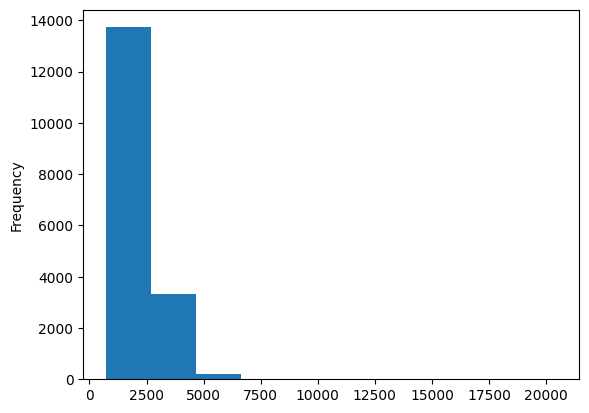

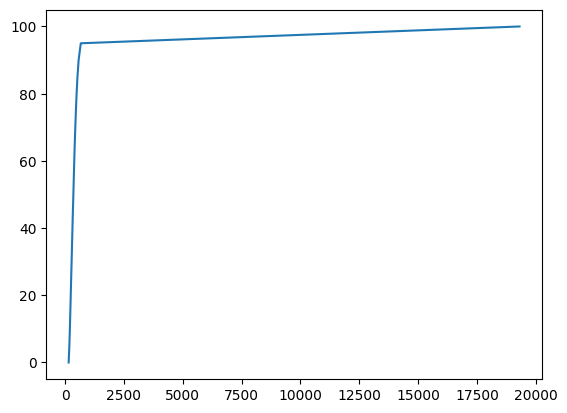

664.0


In [4]:
df.columns     # Next distribution dekhte hai vo bar chart wale command se
# df["score"].value_counts().plot.bar()  # Run karo
df["full_text"].str.len().plot.hist()    # Run this...??
plt.show()
length_word=[len(i.split(" ")) for i in df["full_text"]]
length_word.sort(reverse=True)
percentile_range=range(0,101,5)
x_axis=np.percentile(length_word,percentile_range)
plt.plot(x_axis,percentile_range)
plt.show()
print(np.percentile(length_word,95))


In [5]:
!pip install sentencepiece  #Run this one

In [6]:
import sentencepiece as spm


def prepare_data(df, column_name, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        for text in df[column_name]:
            f.write(text + '\n')

prepare_data(df, 'full_text', 'essays.txt')

# So look here iske upar wale cell me dekho



def train_sentencepiece(input_file, model_prefix, vocab_size=8000, model_type='bpe'):
    spm.SentencePieceTrainer.train(
        input=input_file,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        model_type=model_type,
        character_coverage=1.0,
        pad_id=0,
        unk_id=1,
        bos_id=2,
        eos_id=3,
        pad_piece='[PAD]',
        unk_piece='[UNK]',
        bos_piece='[BOS]',
        eos_piece='[EOS]'
    )

train_sentencepiece('essays.txt', 'essay_sp', vocab_size=8000)




sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: essays.txt
  input_format: 
  model_prefix: essay_sp
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: [UNK]
  bos_piece: [BOS]
  eos_piece: [EOS]
  pad_piece: [PAD]
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_p

In [7]:

sp = spm.SentencePieceProcessor()
sp.load('essay_sp.model')
#encoded_essays = [sp.encode(i for i in df["full_text"])]



def essay_encoder(df,encoder_model,max_len=500):
    failsafe=0
    encoded_df=[]
    for i in df:
        encoded_text=encoder_model.encode(i)
        if len(encoded_text)>=max_len:
            encoded_text=encoded_text[:max_len]
        if len(encoded_text)<max_len:
            encoded_text=np.pad(encoded_text,(0,max_len-len(encoded_text)))
        encoded_df.append(encoded_text)
    return encoded_df
       
        
          


encoded_data=np.array(essay_encoder(df["full_text"],sp,max_len=500))
normalized_scores=df["score"]/6
#print("hi"+sp.decode([0])+"helo")


In [8]:
#we do 70,15,15 split 
tsplit_len=int(0.7*len(encoded_data))
tvsplit_len=int(0.15*len(encoded_data))
x_train=encoded_data[:tsplit_len]
x_test=encoded_data[tsplit_len:tvsplit_len+tsplit_len]
x_val=encoded_data[tsplit_len+tvsplit_len:]

y_train=normalized_scores[:tsplit_len]
y_test=normalized_scores[tsplit_len:tvsplit_len+tsplit_len]
y_val=normalized_scores[tsplit_len+tvsplit_len:]
# print(len(df["full_text"]),len(x_train)+len(x_test)+len(x_val),len(y_train)+len(y_test)+len(y_val))

In [9]:
print(len(x_test),len(y_test),len(x_train),len(y_train),len(x_val),len(y_val))

2596 2596 12114 12114 2597 2597


In [10]:
print(x_train.shape)

(12114, 500)


In [12]:
pip install Attention

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [44]:
import tensorflow as tf
from tensorflow import keras

class AttentionLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = keras.backend.squeeze(keras.backend.tanh(keras.backend.dot(x, self.W) + self.b), axis=-1)
        at = keras.backend.softmax(et)
        at = keras.backend.expand_dims(at, axis=-1)
        output = x * at
        return keras.backend.sum(output, axis=1)

def make_model(vocab_size, embedding_dim, max_length, rnn_units=64, num_attention_heads=3):
    input_layer = keras.layers.Input(shape=(max_length,))
    embedding = keras.layers.Embedding(vocab_size, embedding_dim)(input_layer)
    lstm1 = keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True))(embedding)
    dense1 = keras.layers.Dense(512, activation='relu')(lstm1)
    lstm2 = keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True))(dense1)
    
    # Multiple attention heads
    attention_outputs = []
    for _ in range(num_attention_heads):
        attention_output = AttentionLayer()(lstm2)
        attention_outputs.append(attention_output)
    
    # Concatenate attention outputs
    if num_attention_heads > 1:
        attention_concat = keras.layers.Concatenate()(attention_outputs)
    else:
        attention_concat = attention_outputs[0]
    
    dense2 = keras.layers.Dense(512, activation='sigmoid')(attention_concat)
    output = keras.layers.Dense(1)(dense2)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    return model

model = make_model(vocab_size=8000, embedding_dim=512, max_length=500, rnn_units=512, num_attention_heads=3)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [45]:
model.summary() #😒

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 500, 512)  │  4,096,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 500, 1024) │  4,198,400 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 500, 512)  │    524,800 │ bidirectional_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 500, 1024) │  4,198,400 │ dense_12[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_1   │ (None, 1024)      │      1,524 │ bidirectional_9[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_2   │ (None, 1024)      │      1,524 │ bidirectional_9[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_3   │ (None, 1024)      │      1,524 │ bidirectional_9[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3072)      │          0 │ attention_layer_… │
│ (Concatenate)       │                   │            │ attention_layer_… │
│                     │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 512)       │  1,573,376 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │        513 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,596,061 (55.68 MB)

 Trainable params: 14,596,061 (55.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(x_train,y_train,epochs=3,batch_size=128, validation_data=(x_val,y_val))


Epoch 1/3
36/95 ━━━━━━━━━━━━━━━━━━━━ 46s 781ms/step - loss: 0.0083 - mae: 0.0714

In [23]:
#test_loss, test_mae = model.evaluate(x_test, y_test)
#print(f"Test MAE: {test_mae}")
prediction=model.predict(x_test)

#print("actual_score=",y_test[0],"Predicted_score=",predection[0]*6)

82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step


In [56]:
def encode_input(text,encoder_model,max_len=500):
    text=encoder_model.encode(text)
    if len(text)>=max_len:
            text=text[:max_len]
    if len(text)<max_len:
        text=np.pad(text,(0,max_len-len(text)))
    return np.array(text)

In [61]:
essay = """Montaigne's "attempts" grew out of his commonplacing.[5] Inspired in particular by the works of Plutarch, a translation of whose Œuvres Morales (Moral works) into French had just been published by Jacques Amyot, Montaigne began to compose his essays in 1572; the first edition, entitled Essais, was published in two volumes in 1580.[6] For the rest of his life, he continued revising previously published essays and composing new ones. A third volume was published posthumously; together, their over 100 examples are widely regarded as the predecessor of the modern essay.
Europe

While Montaigne's philosophy was admired and copied in France, none of his most immediate disciples tried to write essays. But Montaigne, who liked to fancy that his family (the Eyquem line) was of English extraction, had spoken of the English people as his "cousins", and he was early read in England, notably by Francis Bacon.[7]

Bacon's essays, published in book form in 1597 (only five years after the death of Montaigne, containing the first ten of his essays),[7] 1612, and 1625, were the first works in English that described themselves as essays. Ben Jonson first used the word essayist in 1609, according to the Oxford English Dictionary. Other English essayists included Sir William Cornwallis, who published essays in 1600 and 1617 that were popular at the time,[7] Robert Burton (1577–1641) and Sir Thomas Browne (1605–1682). In Italy, Baldassare Castiglione wrote about courtly manners in his essay Il Cortigiano. In the 17th century, the Spanish Jesuit Baltasar Gracián wrote about the theme of wisdom.[8]

In England, during the Age of Enlightenment, essays were a favored tool of polemicists who aimed at convincing readers of their position; they also featured heavily in the rise of periodical literature, as seen in the works of Joseph Addison, Richard Steele and Samuel Johnson. Addison and Steele used the journal Tatler (founded in 1709 by Steele) and its successors as storehouses of their work, and they became the most celebrated eighteenth-century essayists in England. Johnson's essays appear during the 1750s in various similar publications.[7] As a result of the focus on journals, the term also acquired a meaning synonymous with "article", although the content may not the strict definition. On the other hand, Locke's An Essay Concerning Human Understanding is not an essay at all, or cluster of essays, in the technical sense, but still it refers to the experimental and tentative nature of the inquiry which the philosopher was undertaking."""

In [43]:
essay = "HI i am Prime"

In [62]:
prediction_str = encode_input(essay,sp,max_len=500)
# print(np.array(prediction_str).shape)
prediction_str = prediction_str.reshape(1,500)

In [63]:
print(model.predict([[prediction_str]])*6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
[[2.4107418]]


In [25]:
model.save("/kaggle/working/model.keras")

In [26]:
model1 = keras.models.load_model("/kaggle/working/m.keras")

ValueError: File not found: filepath=/kaggle/working/m.keras. Please ensure the file is an accessible `.keras` zip file.

In [67]:
model1

<Sequential name=sequential, built=True>

In [ ]:
def essay_encoder(text,encoder_model,max_len=500):
    failsafe=0
    encoded_df=[]
    
    encoded_text=encoder_model.encode(i)
    if len(encoded_text)>=max_len:
        encoded_text=encoded_text[:max_len]
    if len(encoded_text)<max_len:
        encoded_text=np.pad(encoded_text,(0,max_len-len(encoded_text)))
    encoded_df.append(encoded_text)
    
    return encoded_df

predict = model1.predict(["HI Weather is very good"])

In [44]:
print("Actual Score =",list(y_test[0:1]*6),"Predicted Score=", np.round(prediction[0]*6),prediction[0]*6)

Actual Score = [2.0] Predicted Score= [2.] [2.188599]


In [49]:
for i in range(25):
    print("Actual score=",list(y_test[i:i+1]*6),"Predicted score=",np.round(prediction[i]*6))

Actual score= [2.0] Predicted score= [2.]
Actual score= [2.0] Predicted score= [2.]
Actual score= [5.0] Predicted score= [4.]
Actual score= [5.0] Predicted score= [4.]
Actual score= [3.0] Predicted score= [3.]
Actual score= [4.0] Predicted score= [3.]
Actual score= [3.0] Predicted score= [3.]
Actual score= [5.0] Predicted score= [4.]
Actual score= [2.0] Predicted score= [3.]
Actual score= [2.0] Predicted score= [2.]
Actual score= [4.0] Predicted score= [5.]
Actual score= [6.0] Predicted score= [4.]
Actual score= [3.0] Predicted score= [4.]
Actual score= [3.0] Predicted score= [3.]
Actual score= [2.0] Predicted score= [2.]
Actual score= [1.0] Predicted score= [2.]
Actual score= [4.0] Predicted score= [4.]
Actual score= [2.0] Predicted score= [2.]
Actual score= [5.0] Predicted score= [5.]
Actual score= [2.0] Predicted score= [2.]
Actual score= [3.0] Predicted score= [4.]
Actual score= [4.0] Predicted score= [3.]
Actual score= [3.0] Predicted score= [3.]
Actual score= [3.0] Predicted scor

In [24]:
count = 0
num_sample = len(y_test)
for i in range(num_sample):
    if list(y_test[i:i+1]*6)[0]==np.round(predictions[i]*6)[0]:     
        count+=1
#         print("Actual score=",list(y_test[i:i+1]*6)[0],"Predicted score=",np.round(prediction[i]*6)[0],"number correct = ",count)
print("incorrect=",num_sample-count,"correct=",count)

NameError: name 'predictions' is not defined

In [24]:
count = 0
num_sample = len(y_test)
for i in range(num_sample):
    if list(y_test[i:i+1]*6)[0]==np.round(prediction[i]*6)[0]:     
        count+=1
#         print("Actual score=",list(y_test[i:i+1]*6)[0],"Predicted score=",np.round(prediction[i]*6)[0],"number correct = ",count)
print("incorrect=",num_sample-count,"correct=",count)

incorrect= 1037 correct= 1559


In [73]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


essay_sp.model	essay_sp.vocab	essays.txt  m.keras  model.keras
